<a href="https://colab.research.google.com/github/ronitsandooja/SarimaProjct/blob/main/project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving generated_dataset.xlsx to generated_dataset.xlsx


In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels openpyxl

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import io

In [7]:
df = pd.read_excel(io.BytesIO(uploaded["generated_dataset.xlsx"]))

In [8]:
df

,CIRCLE,NOMINAL QUARTER,BTS TYPE,TOWN CATEGORY,SITE TYPE,OEM,INSTALLATION PARTNER,INTEGRATION PARTNER,NOMINAL TYPE,TOWER TYPE,...,PRODUCT TYPE,BROAD PROJECT,TSP ASSIGNMENT STATUS,TSP STATUS,DOMAIN,TSP,SR DATE,SP DATE,SO DATE,RFAI DATE
0,Jharkhand,Q2,SPLIT VERSION,URBAN,IBS,Meesho,Fynd,Fynd,SHARING,RTP,...,NEW,UPGRADE,PENDING,SP PENDING,MW,Meesho,2025-03-18,NaT,NaT,NaT
1,Manipur,Q1,SPLIT VERSION,METRO,MACRO,Meesho,Meesho,Meesho,UPGRADE,GBM,...,SHARING,SWAP,PENDING,INTEGRATION PENDING,RAN MW,Nykaa,2024-09-16,2024-12-08,2025-01-13,NaT
2,Uttarakhand,Q1,OUTDOOR,URBAN PERIPHERAL,IBS,CRED,Fynd,Fynd,UPGRADE,RTP,...,SHARING,UPGRADE,PENDING,OA PENDING,MW,Dunzo,2024-02-17,2024-04-26,2025-02-07,2025-03-02
3,Maharashtra,Q1,INDOOR,RURAL,MICRO,CRED,Dunzo,Dunzo,UPGRADE,GBT,...,SHARING,UPGRADE,PENDING,SO PENDING,RAN MW,Oyo,2024-12-26,2025-04-15,NaT,NaT
4,West Bengal,Q3,INDOOR,METRO,MICRO,CRED,Oyo,Khatabook,SHARING,RTP,...,SHARING,MW,INACTIVE,RFAI PENDING,RAN MW,Nykaa,2024-06-19,2025-02-11,2025-05-11,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Sikkim,Q1,SPLIT VERSION,URBAN PERIPHERAL,MACRO,Dunzo,Apna,Apna,SHARING,GBT,...,SHARING,MW,REJECTED,OA PENDING,MW,Meesho,2024-02-08,2025-03-07,2025-06-23,2025-06-24
9996,Gujarat,Q1,SPLIT VERSION,URBAN PERIPHERAL,MICRO,Oyo,CRED,CRED,NEW,POLE,...,NEW,SWAP,REJECTED,RFAI RECIVED,FIBRE,Oyo,2024-09-24,2025-04-27,2025-05-29,2025-06-10
9997,Arunachal Pradesh,Q3,INDOOR,RURAL,MACRO,CRED,Apna,Apna,NEW,GBM,...,NEW,OTHERS,REJECTED,MS2 PENDING,FIBRE,Nykaa,2024-01-13,2024-02-01,2024-07-28,2024-08-01
9998,Punjab,Q2,TOWER TOP,URBAN,SMALL CELL,Meesho,Fynd,Fynd,NEW,GBM,...,UPGRADE,SWAP,ACTIVE,OA PENDING,RAN MW,Oyo,2024-09-28,2025-06-09,2025-06-11,2025-06-17


Correcting date time...

In [10]:
df["SR DATE"] = pd.to_datetime(df["SR DATE"], errors='coerce')
df["SP DATE"] = pd.to_datetime(df["SP DATE"], errors='coerce')
df["SO DATE"] = pd.to_datetime(df["SO DATE"], errors='coerce')
df["RFAI DATE"] = pd.to_datetime(df["RFAI DATE"], errors='coerce')

In [11]:
def sp_delay(row):
    if pd.isna(row["SP DATE"]): return np.nan
    return 1 if (row["SP DATE"] - row["SR DATE"]).days > 10 else 0

def so_delay(row):
    if pd.isna(row["SO DATE"]) or pd.isna(row["SP DATE"]): return np.nan
    return 0 if row["SO DATE"] <= (row["SP DATE"] + pd.Timedelta(days=5)) else 1

def rfai_delay(row):
    if pd.isna(row["RFAI DATE"]) or pd.isna(row["SO DATE"]): return np.nan
    return 0 if row["RFAI DATE"] <= (row["SO DATE"] + pd.Timedelta(days=30)) else 1

In [12]:
df["SP_DELAY"] = df.apply(sp_delay, axis=1)
df["SO_DELAY"] = df.apply(so_delay, axis=1)
df["RFAI_DELAY"] = df.apply(rfai_delay, axis=1)

print("New delay columns added...")

New delay columns added...


In [13]:
df[["SR DATE", "SP DATE", "SO DATE", "RFAI DATE", "SP_DELAY", "SO_DELAY", "RFAI_DELAY"]]

,SR DATE,SP DATE,SO DATE,RFAI DATE,SP_DELAY,SO_DELAY,RFAI_DELAY
0,2025-03-18,NaT,NaT,NaT,NaN,NaN,NaN
1,2024-09-16,2024-12-08,2025-01-13,NaT,1.0,1.0,NaN
2,2024-02-17,2024-04-26,2025-02-07,2025-03-02,1.0,1.0,0.0
3,2024-12-26,2025-04-15,NaT,NaT,1.0,NaN,NaN
4,2024-06-19,2025-02-11,2025-05-11,NaT,1.0,1.0,NaN
...,...,...,...,...,...,...,...
9995,2024-02-08,2025-03-07,2025-06-23,2025-06-24,1.0,1.0,0.0
9996,2024-09-24,2025-04-27,2025-05-29,2025-06-10,1.0,1.0,0.0
9997,2024-01-13,2024-02-01,2024-07-28,2024-08-01,1.0,1.0,0.0
9998,2024-09-28,2025-06-09,2025-06-11,2025-06-17,1.0,0.0,0.0


In [14]:
# SARIMA FORECAST FUNCTION
def prepare_time_series(delay_col):
    ts = df.groupby("SR DATE")[delay_col].mean().fillna(0)
    ts = ts.asfreq("D", fill_value=0)
    return ts

def run_sarima(ts_series, delay_name):
    print(" SARIMA FORECAST FOR ", delay_name)

    adf_result = adfuller(ts_series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] > 0.05:
        print("Time series NOT stationary → Differencing will be applied")
#p,d,q ==> d---Differencing
    model = SARIMAX(ts_series,
                    order=(1,1,1),
                    seasonal_order=(1,1,1,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)
    print(sarima_fit.summary())

    forecast = sarima_fit.get_forecast(steps=30)
    forecast_df = forecast.summary_frame()

    plt.figure(figsize=(12,5))
    plt.plot(ts_series, label=f"Historical {delay_name} Rate")
    plt.plot(forecast_df["mean"], label=f"Forecasted {delay_name} Rate", color="red")
    plt.fill_between(forecast_df.index, forecast_df["mean_ci_lower"], forecast_df["mean_ci_upper"],
                     color="pink", alpha=0.3)
    plt.legend()
    plt.title(f"{delay_name} Trend Forecast (Next 30 Days)")
    plt.show()

 SARIMA FORECAST FOR  SP_DELAY
ADF Statistic: 7.415192167191004
p-value: 1.0
Time series NOT stationary → Differencing will be applied
                                     SARIMAX Results                                      
Dep. Variable:                           SP_DELAY   No. Observations:                  532
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 659.320
Date:                            Sun, 27 Jul 2025   AIC                          -1308.640
Time:                                    21:14:19   BIC                          -1287.517
Sample:                                01-01-2024   HQIC                         -1300.355
                                     - 06-15-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

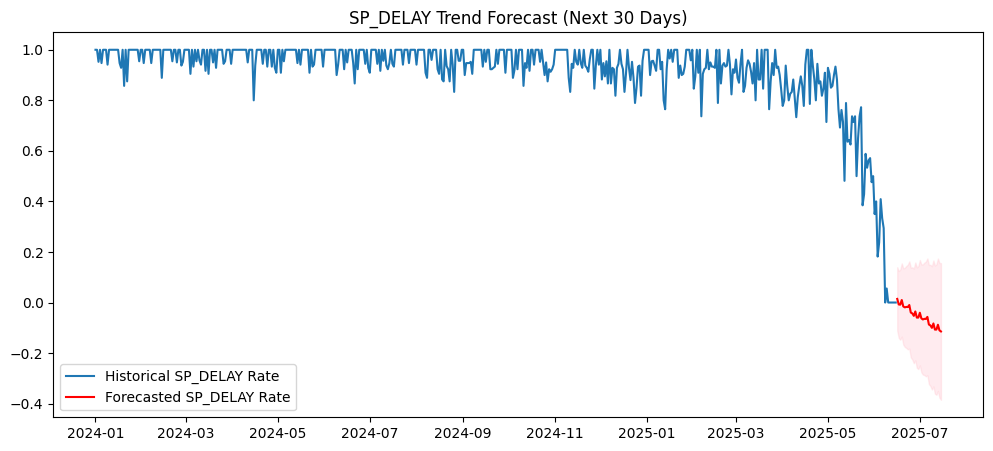

In [16]:
print("SARIMA MODEL FOR SP")

sp_ts = prepare_time_series("SP_DELAY")
run_sarima(sp_ts, "SP_DELAY")


SARIMA MODEL FOR SO
 SARIMA FORECAST FOR  SO_DELAY
ADF Statistic: 2.8067030122616714
p-value: 1.0
Time series NOT stationary → Differencing will be applied
                                     SARIMAX Results                                      
Dep. Variable:                           SO_DELAY   No. Observations:                  532
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 476.064
Date:                            Sun, 27 Jul 2025   AIC                           -942.128
Time:                                    21:16:17   BIC                           -921.005
Sample:                                01-01-2024   HQIC                          -933.843
                                     - 06-15-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

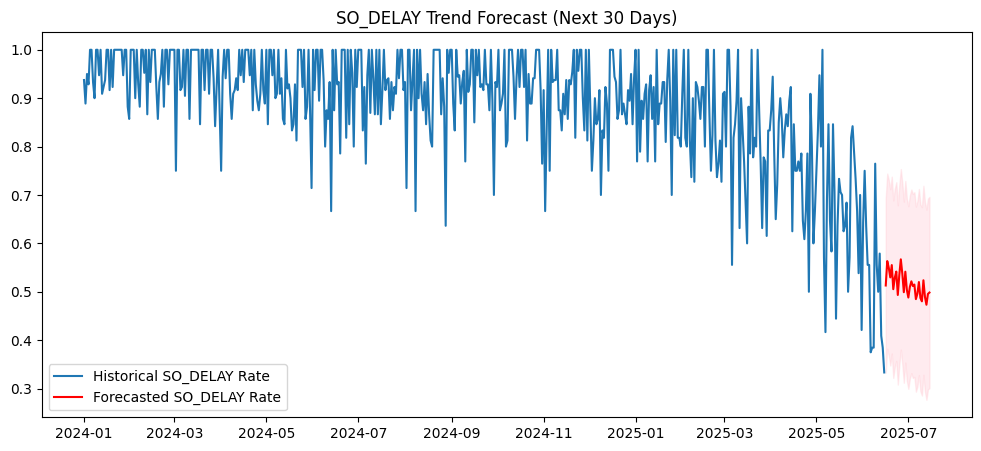

In [17]:
print("SARIMA MODEL FOR SO")

so_ts = prepare_time_series("SO_DELAY")
run_sarima(so_ts, "SO_DELAY")

SARIMA MODEL FOR RFAI
 SARIMA FORECAST FOR  RFAI_DELAY
ADF Statistic: -0.640651545718032
p-value: 0.8615293855898003
Time series NOT stationary → Differencing will be applied
                                     SARIMAX Results                                      
Dep. Variable:                         RFAI_DELAY   No. Observations:                  532
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 267.087
Date:                            Sun, 27 Jul 2025   AIC                           -524.174
Time:                                    21:16:20   BIC                           -503.051
Sample:                                01-01-2024   HQIC                          -515.889
                                     - 06-15-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

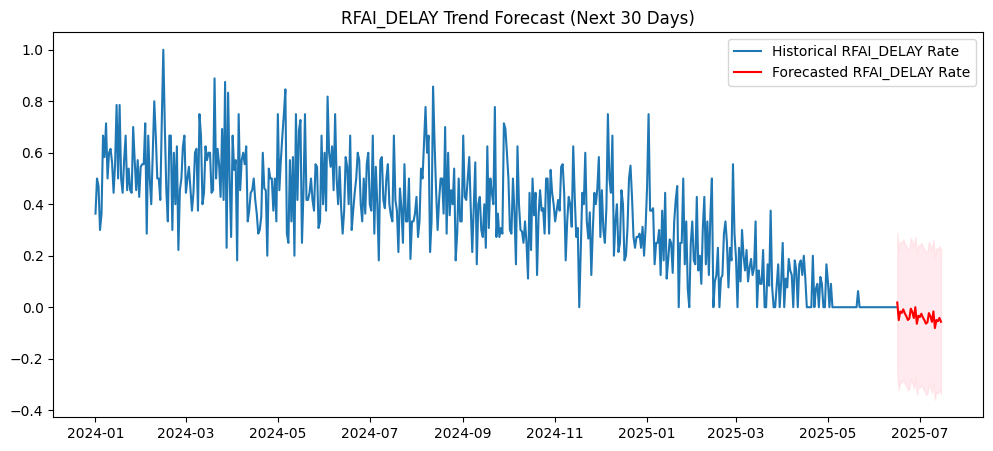

In [18]:
print("SARIMA MODEL FOR RFAI")

rfai_ts = prepare_time_series("RFAI_DELAY")
run_sarima(rfai_ts, "RFAI_DELAY")

In [20]:
df.to_excel("updated_dataset_with_delays.xlsx", index=False)
print("Updated dataset saved as updated_dataset_with_delays.xlsx")

Updated dataset saved as updated_dataset_with_delays.xlsx


### **Short Summary – What This SARIMA Model is Doing**

1. **Input:**
   Your dataset with dates (`SR DATE`, `SP DATE`, `SO DATE`, `RFAI DATE`).

2. **Preprocessing:**

   * Calculates **3 delay indicators**:

     * **SP\_DELAY** → 1 if SP\_DATE is more than 10 days after SR\_DATE.
     * **SO\_DELAY** → 1 if SO\_DATE is more than 5 days after SP\_DATE.
     * **RFAI\_DELAY** → 1 if RFAI\_DATE is more than 30 days after SO\_DATE.
       *(0 means "No Delay", 1 means "Delayed")*

3. **Time-Series Conversion:**

   * Groups delays **per SR\_DATE** and calculates daily **average delay rate** (e.g., if 30% of sites delayed on that day → 0.3).

4. **SARIMA Model:**

   * **Fits a Seasonal ARIMA (SARIMA) model** on each delay time series (SP, SO, RFAI).
   * Learns the trend, seasonality, and past patterns of delays.

5. **Forecasting:**

   * Predicts the **trend of delays for the next 30 days**.
   * Outputs graphs showing whether delay rates are **increasing, decreasing, or stable**.

---

✅ **In short:**
**It’s not predicting individual True/False delays for each row but forecasting the *overall daily delay trend* over time.**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [28]:
#Training func
def train_delay_model(target_col):
    print(f" TRAINING MODEL FOR {target_col}")

    feature_cols = ["CIRCLE", "NOMINAL QUARTER", "BTS TYPE", "TOWN CATEGORY",
                "SITE TYPE", "OEM", "INSTALLATION PARTNER", "NOMINAL TYPE",
                "TOWER TYPE", "TOWER HEIGHT", "BUILDING HEIGHT", "PRODUCT TYPE",
                "BROAD PROJECT", "TSP ASSIGNMENT STATUS", "TSP STATUS", "DOMAIN", "TSP"]

    X = df[feature_cols]
    y = df[target_col]

    # Remove rows with NaN in target
    X = X[~y.isna()]
    y = y.dropna()

    # Encode categorical variables
    label_encoders = {}
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = X[col].astype(str)
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le

    # Impute missing values in features
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(X)

    # Split into train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print("\n Accuracy:", accuracy_score(y_test, y_pred))
    print("\n Classification Report:\n", classification_report(y_test, y_pred))
    print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Sample Predictions
    print("\nSample Predictions (0 = No Delay, 1 = Delay):", model.predict(X_test[:5]))
    return model

In [29]:
model_sp = train_delay_model("SP_DELAY")

 TRAINING MODEL FOR SP_DELAY

 Accuracy: 0.9145106861642295

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       152
         1.0       0.91      1.00      0.96      1626

    accuracy                           0.91      1778
   macro avg       0.46      0.50      0.48      1778
weighted avg       0.84      0.91      0.87      1778


 Confusion Matrix:
 [[   0  152]
 [   0 1626]]

Sample Predictions (0 = No Delay, 1 = Delay): [1. 1. 1. 1. 1.]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
model_so = train_delay_model("SO_DELAY")

 TRAINING MODEL FOR SO_DELAY

 Accuracy: 0.8828025477707007

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       184
         1.0       0.88      1.00      0.94      1386

    accuracy                           0.88      1570
   macro avg       0.44      0.50      0.47      1570
weighted avg       0.78      0.88      0.83      1570


 Confusion Matrix:
 [[   0  184]
 [   0 1386]]

Sample Predictions (0 = No Delay, 1 = Delay): [1. 1. 1. 1. 1.]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
model_rfai = train_delay_model("RFAI_DELAY")

df.to_excel("classified_dataset.xlsx", index=False)
print("\n Updated dataset saved as classified_dataset.xlsx")

 TRAINING MODEL FOR RFAI_DELAY

 Accuracy: 0.6439461883408072

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       724
         1.0       0.35      0.02      0.03       391

    accuracy                           0.64      1115
   macro avg       0.50      0.50      0.41      1115
weighted avg       0.54      0.64      0.52      1115


 Confusion Matrix:
 [[711  13]
 [384   7]]

Sample Predictions (0 = No Delay, 1 = Delay): [0. 0. 0. 0. 0.]

 Updated dataset saved as classified_dataset.xlsx
